<br/>

$$ \huge{\underline{\textbf{ Q-Learning }}} $$

<br/>

<img src="assets/0605_Q_Learning.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 6.5 </center>

<br/>

In [413]:
def q_learning(env, ep, gamma, alpha, eps, mts=float('inf')):
    """Q-Learning (off-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    ts = 0
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S, Q, eps)
            S_, R, done = env.step(A)
            max_Q = np.max([Q[S_,a] for a in env.act_space])
            Q[S,A] = Q[S,A] + alpha * (R + gamma * max_Q - Q[S,A])
            S = S_
            if done: break
                
            ts += 1
            if ts >= mts:
                return Q
                
    return Q

Helper functions:

In [414]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

# Solve Cliff Walking

In [415]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
# from helpers_0604 import plot_windy

Cliff Walking environment, as described in the book example 6.6, along with our x,y convention.
<img src="assets/0605_cliffwalking.png"/>

In [420]:
class CliffWalkingEnv:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 0        # agent initial position
        return (0, 0)
        
    def step(self, action):
        # actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x not in [0, 11] and self._y == 0:  # CLIFF
            self._x, self._y = 0, 0                  #  teleport to start
            return (self._x, self._y), -100, False   #  return -100 reward
        if self._x == 11 and self._y == 0:           # GOAL
            return (self._x, self._y), -1, True      #  -1, terminate
        return (self._x, self._y), -1, False         # NORMAL
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action. Does not teleport."""
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 11)   # x range is [0..11]
        y = np.clip(y, 0, 3)   # y range is [0..3]
        return x, y
    
    def get_path(self, Q):
        x, y = 0, 0       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                           # save to path
            if x not in [0, 11] and y == 0:              # CLIFF
                path.append((0, 0))
            if x == 11 and y == 0:  break                 # if goal: break
        return path

Create environment

In [421]:
env = CliffWalkingEnv()

Solve. Note that 10k episodes doesn't always find optimal policy.

In [468]:
Q = sarsa(env, ep=1000, gamma=1., alpha=.5, eps=.1, mts=float('inf'))

Plot

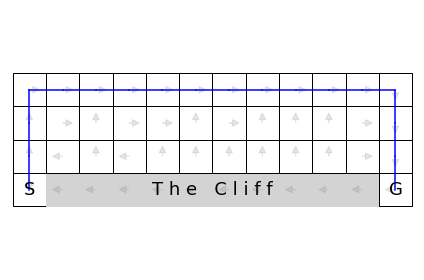

In [469]:
path = env.get_path(Q)
plot_cliffwalk(Q, path)

In [470]:
Q = q_learning(env, ep=100, gamma=1., alpha=.5, eps=.1)

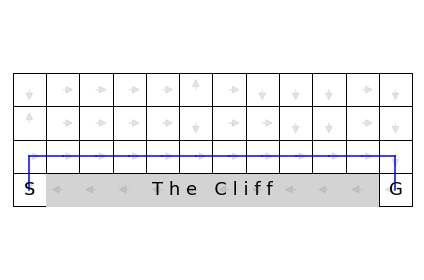

In [471]:
path = env.get_path(Q)
plot_cliffwalk(Q, path)

In [430]:
arr = np.zeros([12, 4, 4])
for x in range(12):
    for y in range(4):
        for a in [0, 1, 2, 3]:
            arr[x, y, a] = Q[(x,y),a]

In [431]:
print(arr[:,:,0].T[::-1].round(1))  # <-

[[-14.5 -13.1 -13.1 -11.5 -11.3  -9.4  -9.6  -8.4  -7.5  -6.7  -5.8  -4.3]
 [-14.  -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4. ]
 [-13.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3. ]
 [-14.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]]


In [432]:
print(arr[:,:,1].T[::-1].round(1))  # v

[[ -13.9  -13.   -12.   -11.   -10.    -9.    -8.    -7.    -6.    -5.
    -4.    -3. ]
 [ -13.   -12.   -11.   -10.    -9.    -8.    -7.    -6.    -5.    -4.
    -3.    -2. ]
 [ -14.  -113.  -113.  -113.  -113.  -113.  -113.  -113.  -113.  -113.
  -113.    -1. ]
 [ -14.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0. ]]


In [433]:
print(arr[:,:,2].T[::-1].round(1))  # ->

[[ -13.9  -13.   -12.   -11.   -10.    -9.    -8.    -7.    -6.    -5.
    -4.    -3.7]
 [ -13.   -12.   -11.   -10.    -9.    -8.    -7.    -6.    -5.    -4.
    -3.    -3. ]
 [ -12.   -11.   -10.    -9.    -8.    -7.    -6.    -5.    -4.    -3.
    -2.    -2. ]
 [-113.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0. ]]


In [434]:
print(arr[:,:,3].T[::-1].round(1))  # ^

[[-14.4 -13.7 -12.4 -11.2 -10.8  -9.8  -8.8  -7.3  -6.3  -5.9  -4.7  -3. ]
 [-14.8 -14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4. ]
 [-14.  -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3. ]
 [-13.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]]


In [435]:
print(np.max(arr, axis=-1).T[::-1].round(1))

[[-13.9 -13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3. ]
 [-13.  -12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2. ]
 [-12.  -11.  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1. ]
 [-13.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]]


In [436]:
amax_Ti = np.argmax(arr, axis=-1).T[::-1]

In [437]:
a2w = {'0':'<', '1':'v', '2':'>', '3':'^'}
amax_str = np.array(amax_Ti, dtype=str)
for i in range(amax_str.shape[0]):
    for j in range(amax_str.shape[1]):
        amax_str[i,j] = a2w[amax_str[i,j]]

In [342]:
amax_str

array([['>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '<'],
       ['^', '^', '^', '^', '^', '>', '>', '^', '>', '^', '^', '^'],
       ['^', '<', '^', '^', '<', '^', '^', '^', '^', '^', '>', '^'],
       ['^', '<', '<', '<', '<', '<', '<', '<', '<', '<', '<', '^']],
      dtype='<U21')

In [10]:
import matplotlib.patches as patches

In [472]:
def plot_cliffwalk(Q=None, path=None, color='blue', saveimg=None):
    """Plot windy gridworld.
    
    Will plot optimal action for each cell, according to 'Q'
    and blue line following 'path' parameter
    
    Params:
        Q    - optional, dictionary mappting [(x,y),action] -> float
        path - optional, list [(x1,y1), (x2,y2), ...] of agent steps
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 11.5)
    ax.set_ylim(-.5, 3.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    ax.set_aspect('equal', 'datalim')

    ax.text(0, 0, 'S', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(11, 0, 'G', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(5.5, 0, 'T h e   C l i f f', fontsize=18, horizontalalignment='center', verticalalignment='center')
    
    for x in range(12):
        for y in range(4):
            if x not in [0, 11] and y == 0:  # cliff
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=True, color='lightgray'))    
            else:
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))  # cells

            if Q is not None:
                params = {'head_width':0.2, 'head_length':0.2, 'color':'gray', 'alpha':.2}
                A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])  # pick best action
                if A_star == 3:    ax.arrow(x, y, 0,  .1, **params)  # up
                elif A_star == 1:  ax.arrow(x, y, 0, -.1, **params)  # down
                elif A_star == 0:  ax.arrow(x, y, -.1, 0, **params)  # left
                elif A_star == 2:  ax.arrow(x, y,  .1, 0, **params)  # right

    if path is not None:
        for i in range(len(path)-1):
            x, y = path[i]
            x_, y_ = path[i+1]
            ax.plot([x, x_], [y, y_], color=color, alpha=1.)

    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()

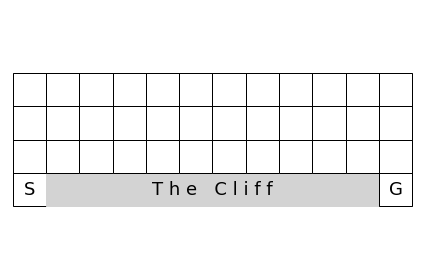

In [38]:
plot_cliffwalk()

In [76]:
import pdb

In [323]:
def sarsa(env, ep, gamma, alpha, eps, mts=float('inf')):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            pick = argmax_rand([Q[st,a] for a in env.act_space])
            # print(st, ':', [Q[st,a] for a in env.act_space], ' -> ', pick)
            return pick
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    # pdb.set_trace()
    
    ts = 0
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            if done: break
                
            ts += 1
            if ts >= mts:
                return Q
                
    return Q

# Recreate Example 6.5 figures 

### Mini figure

This assume previous section computed optimal Q correctly, if not repeat or increase nb episodes.

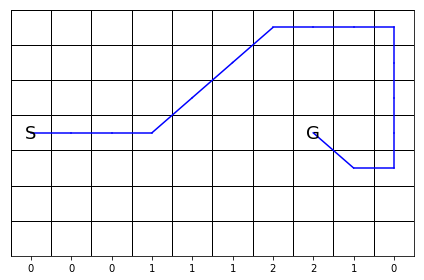

In [10]:
plot_windy(Q=None, path=optimal_path, savepath='assets/fig_0604_path.png')